In [109]:
import numpy as np
import tensorflow as tf
import scipy
import os
from os import listdir
from scipy.io import loadmat
import pickle
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from keras import regularizers
from keras import activations
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
from IPython.display import Image

In [110]:
dataset_path = 'Project_Vrajesh/eeg_feature_smooth'

In [111]:
directories = ["/Project_Vrajesh/eeg_feature_smooth/{}/".format(i+1) for i in range(3)]

# As described in the description of the dataset, the channel_coords are defined below
channel_coords = [['0', '0', 'AF3', 'FP1', 'FPZ', 'FP2', 'AF4', '0', '0'], ['F7', 'F5', 'F3', 'F1', 'FZ', 'F2', 'F4', 'F6', 'F8'], ['FT7', 'FC5', 'FC3', 'FC1', 'FCZ', 'FC2', 'FC4', 'FC6', 'FT8'], ['T7', 'C5', 'C3', 'C1', 'CZ', 'C2', 'C4', 'C6', 'T8'], ['TP7', 'CP5', 'CP3', 'CP1', 'CPZ', 'CP2', 'CP4', 'CP6', 'TP8'], ['P7', 'P5', 'P3', 'P1', 'PZ', 'P2', 'P4', 'P6', 'P8'], ['0', 'PO7', 'PO5', 'PO3', 'POZ', 'PO4', 'PO6', 'PO8', '0'], ['0', '0', 'CB1', 'O1', 'OZ', 'O2', 'CB2', '0', '0']]
# As defined in the description of the dataset, the channel_list is defined below
channel_list = ['FP1', 'FPZ', 'FP2', 'AF3', 'AF4', 'F7', 'F5', 'F3', 'F1', 'FZ', 'F2', 'F4', 'F6', 'F8', 'FT7', 'FC5', 'FC3', 'FC1', 'FCZ', 'FC2', 'FC4', 'FC6', 'FT8', 'T7', 'C5', 'C3', 'C1', 'CZ', 'C2', 'C4', 'C6', 'T8', 'TP7', 'CP5', 'CP3', 'CP1', 'CPZ', 'CP2', 'CP4', 'CP6', 'TP8', 'P7', 'P5', 'P3', 'P1', 'PZ', 'P2', 'P4', 'P6', 'P8', 'PO7', 'PO5', 'PO3', 'POZ', 'PO4', 'PO6', 'PO8', 'CB1', 'O1', 'OZ', 'O2', 'CB2']

# Initialize an empty dictionary to store the coordinates of each channel
coord_dict = {}  


'''The outer loop iterates over each index n in the range of the length of channel_list, which represents each channel. 
Within this loop, it goes through each sublist l in channel_coords using enumerate() to also get the index i of the sublist.

Inside the innermost loop, it iterates through each element x in the sublist l, along with its index j. 
It checks if the current channel name (channel_list[n]) matches the element x in the sublist. 
If there's a match, it means the coordinates of the channel have been found. 
The coordinates (i, j) are then stored in the coord_dict dictionary, with the key being the index n, representing the channel index.

This process continues for each channel in channel_list, ensuring that the coordinates of each channel are correctly mapped and stored in the coord_dict dictionary. 
Finally, the coord_dict dictionary is printed, containing the coordinates of each channel.'''

for n in range(len(channel_list)):
    for i, l in enumerate(channel_coords):
        for j, x in enumerate(l):
            if (channel_list[n] == x):
                coord_dict[n] = (i,j)
print(coord_dict)

{0: (0, 3), 1: (0, 4), 2: (0, 5), 3: (0, 2), 4: (0, 6), 5: (1, 0), 6: (1, 1), 7: (1, 2), 8: (1, 3), 9: (1, 4), 10: (1, 5), 11: (1, 6), 12: (1, 7), 13: (1, 8), 14: (2, 0), 15: (2, 1), 16: (2, 2), 17: (2, 3), 18: (2, 4), 19: (2, 5), 20: (2, 6), 21: (2, 7), 22: (2, 8), 23: (3, 0), 24: (3, 1), 25: (3, 2), 26: (3, 3), 27: (3, 4), 28: (3, 5), 29: (3, 6), 30: (3, 7), 31: (3, 8), 32: (4, 0), 33: (4, 1), 34: (4, 2), 35: (4, 3), 36: (4, 4), 37: (4, 5), 38: (4, 6), 39: (4, 7), 40: (4, 8), 41: (5, 0), 42: (5, 1), 43: (5, 2), 44: (5, 3), 45: (5, 4), 46: (5, 5), 47: (5, 6), 48: (5, 7), 49: (5, 8), 50: (6, 1), 51: (6, 2), 52: (6, 3), 53: (6, 4), 54: (6, 5), 55: (6, 6), 56: (6, 7), 57: (7, 2), 58: (7, 3), 59: (7, 4), 60: (7, 5), 61: (7, 6)}


In [112]:
n = 24  # Total number of labels (since each session contained 24 trails while making the dataset)
noise_removal = ['de_movingAve', 'de_LDS', 'psd_movingAve', 'psd_LDS']    # Different smoothining techniques used while removing the noise from the raw_eeg_data
array = np.zeros(shape=(len(directories),len(os.listdir(directories[0])), n, 4, 8, 9, 5, 64)) # features = 4 datatypes*(8 x 9 eeg channel locs)*5 frequency bands*64 timestamps(zero padded) // trials = (3 sessions) x 15 people x 24 labels


'''The outermost loop iterates over each directory path stored in the directories list. For each directory, it prints the directory path.

The second loop iterates over each file in the current directory using os.listdir(directory). 
It loads each file using loadmat() from the scipy.io module, which reads MATLAB files.

Inside this loop, the third loop iterates over each label (totaling n) in the loaded data. It ranges from 0 to n-1.

The fourth loop iterates over each type of noise removal technique stored in the noise_removal list. 
For each noise removal technique, it processes the corresponding EEG data associated with the current label.

Within this loop, it extracts the EEG data using the key derived from the noise removal technique and the label index. 
It then transposes the data to have the channels as the last dimension and pads the data with zeros to ensure uniformity in the number of timestamps.

Finally, the fifth loop iterates over each channel's EEG data in the sample. 
It assigns this EEG data to the corresponding position in the array based on the directory, file, label, noise removal technique, and EEG channel location obtained from the coord_dict.

This process repeats for each directory, file, label, and noise removal technique, effectively populating the array with EEG features extracted from the dataset.'''
for i, directory in enumerate(directories):
    print(directory)
    data = [loadmat(directory + file) for file in os.listdir(directory)]
    for j, total in enumerate(data):
        for k in range(n):
            for l, key in enumerate(noise_removal):
                sample = np.transpose(np.array(total[key + str(j+1)]), (0,2,1))
                sample = np.pad(sample, [(0,0), (0,0), (0, 64-sample.shape[2])])
                for m, channel in enumerate(sample):
                    array[i][j][k][l][coord_dict[m][0]][coord_dict[m][1]] = channel

print(array.shape)

/Project_Vrajesh/eeg_feature_smooth/1/
/Project_Vrajesh/eeg_feature_smooth/2/
/Project_Vrajesh/eeg_feature_smooth/3/
(3, 15, 24, 4, 8, 9, 5, 64)


In [113]:
# The session labels as defined in the excel sheet in the original dataset.
session1_label = [1,2,3,0,2,0,0,1,0,1,2,1,1,1,2,3,2,2,3,3,0,3,0,3]
session2_label = [2,1,3,0,0,2,0,2,3,3,2,3,2,0,1,1,2,1,0,3,0,1,3,1]
session3_label = [1,2,2,1,3,3,3,1,1,2,1,0,2,3,3,0,2,3,0,0,2,0,1,0]
labels = {0: 'neutral', 1: 'sad', 2: 'fear', 3: 'happy'}  # Labels as defined in the dataset

y = np.array(session1_label * 15 + session2_label * 15 + session3_label * 15)  # Since there are a total of 15 people

print(y.shape)

(1080,)


In [114]:
# Reshape the 'array' to collapse the first three dimensions into one, and transpose it
# np.prod(array.shape[0:3]) calculates the product of the first three dimensions,
# effectively collapsing them into one dimension
# The '*' unpacks the remaining dimensions into separate arguments for the reshape function
# The transpose reorders the dimensions to a specific order
X = array.reshape(np.prod(array.shape[0:3]), *array.shape[3:]).transpose(0, 5, 1,2,3,4)
print(X.shape)

# Reshape 'X' to further process it for training
# This step reshapes 'X' to keep the first dimension as it is, while collapsing all other dimensions into one
X = X.reshape(X.shape[0], X.shape[1], np.prod(X.shape[2:]))
print(X.shape)

# Split the dataset into training and testing sets using train_test_split from scikit-learn
# X_train and X_test contain the features, y_train and y_test contain the labels
# test_size=0.2 specifies that 20% of the data will be used for testing, while 80% will be used for training
# random_state=42 ensures reproducibility of the split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

(1080, 64, 4, 8, 9, 5)
(1080, 64, 1440)


In [141]:
def crossval(generate_model, n_epochs, X_train, y_train, X_test, y_test, filename = None):
    """
    Cross-validation function for training and evaluating a model using k-fold cross-validation.

    Args:
    - generate_model: Function that generates the model to be trained.
    - n_epochs: Number of epochs for training.
    - X_train: Features of the training dataset.
    - y_train: Labels of the training dataset.
    - X_test: Features of the testing dataset.
    - y_test: Labels of the testing dataset.
    - filename (optional): Name of the file to save the trained model (default is None).

    Returns:
    - None

    This function performs k-fold cross-validation on the provided training dataset (X_train, y_train).
    It splits the dataset into 'n_splits' folds, trains a model on each fold, and evaluates its performance.
    The best performing model is selected based on the highest accuracy on the validation set.
    Finally, the function prints the average accuracy and standard deviation across all folds, 
    as well as the accuracy on the test set using the best performing model.
    """

    kfold = StratifiedKFold(n_splits=4, shuffle=True, random_state=0)
    bestmodel = None
    bestAcc = 0
    cvscores = []
    fold = 1
    for train, test in kfold.split(X_train, y_train):
        model = generate_model()
        model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
        print('--------------------------------------------------')
        print(f'Training for fold {fold} ...')
        model.fit(X_train[train], y_train[train],epochs=n_epochs, verbose=1) # validation_split=0.2)
        scores = model.evaluate(X_train[test], y_train[test], verbose=1)
        print("Score for fold %d - %s: %.2f%%" % (fold, model.metrics_names[1], scores[1]*100))
        if(scores[1] > bestAcc):
            bestAcc = scores[1]
            bestmodel = model
        cvscores.append(scores[1] * 100)
        fold += 1
    print('--------------------------------------------------')
    print("Avg accuracies: %.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))
    test_loss, test_acc = bestmodel.evaluate(X_test,  y_test, verbose=2)
    print('\nTest accuracy:', test_acc*100, '%')

In [116]:
def single_conv():
    """
    The model is described below:

1. Convolutional Layer:
    - The first layer is a 1-dimensional convolutional layer (Conv1D) with 32 filters, each of size 3.
    - It uses the ReLU activation function to introduce non-linearity.
    - The input shape is determined dynamically based on the shape of input data X.

2. MaxPooling Layer:
    - Following the convolutional layer, there's a MaxPooling1D layer.
    - It performs max pooling with a pool size of 2 and a stride of 2, effectively reducing the dimensionality of the data.

3. Flatten Layer:
    - After the pooling layer, a Flatten layer is added.
    - This layer flattens the input without affecting the batch size, transforming the tensor shape from 3D to 1D.

4. Dense Layers:
    - Next, there are two dense (fully connected) layers with 128 and 32 units respectively.
    - The first dense layer has 128 units and uses the ReLU activation function.
    - The second dense layer has 32 units.

5. Output Layer:
    - Finally, there's an output layer with 4 units, representing the number of classes or output categories.
    - There is no activation function specified for this layer, which means it will output raw logits.
"""
    return tf.keras.Sequential([
    tf.keras.layers.Conv1D(
32, 3, activation='relu',input_shape=X.shape[1:]),
    tf.keras.layers.MaxPooling1D(
    pool_size=2, strides=2, data_format="channels_last"),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(32),
    tf.keras.layers.Dense(4)
])
model = single_conv()
model.summary()

Model: "sequential_75"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_83 (Conv1D)              │ (None, 62, 32)         │       138,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_81 (MaxPooling1D) │ (None, 31, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_44 (Flatten)            │ (None, 992)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_225 (Dense)               │ (None, 128)            │       127,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_226 (Dense)               │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_227 (Dense)               │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 269,636 (1.03 MB)

 Trainable params: 269,636 (1.03 MB)

 Non-trainable params: 0 (0.00 B)

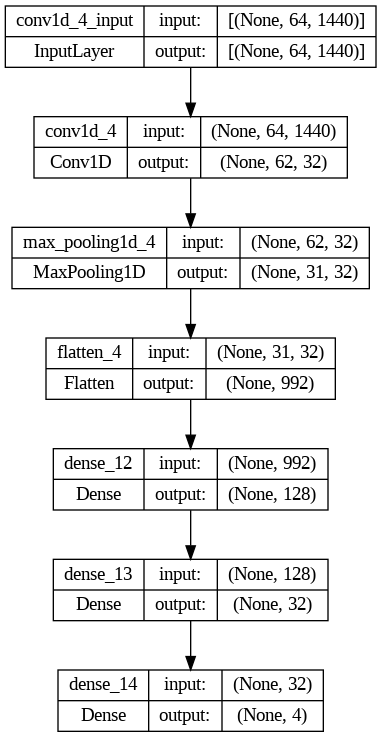

In [133]:
crossval(single_conv, 100, X_train, y_train, X_test, y_test)

/root/anaconda3/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


--------------------------------------------------
Training for fold 1 ...
Epoch 1/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.2314 - loss: 179357408.0000
Epoch 2/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.2543 - loss: 35837924.0000
Epoch 3/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.2313 - loss: 4833238.5000
Epoch 4/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.2122 - loss: 4138174.0000
Epoch 5/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.2464 - loss: 5893056.0000
Epoch 6/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.2400 - loss: 1607987.2500
Epoch 7/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2580 - loss: 2093545.3750
Epoch 8/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2383 - loss: 1006693.6250
Epoch 9/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2417 - loss: 1500491.2500
Epoch 10/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.2452 - loss: 1080271.8750
Epoch 11/10

In [136]:
def lstm_model():
    """
    The model is described below:

1. LSTM Layers:
    - The first layer is an LSTM (Long Short-Term Memory) layer with 64 units.
    - It takes input sequences of variable length and returns sequences (return_sequences=True).
    - The input shape is determined dynamically based on the shape of input data X.
    - LSTM layers are well-suited for sequence data due to their ability to remember long-term dependencies.

    - The second layer is another LSTM layer with 32 units.
    - Unlike the first layer, this LSTM layer does not return sequences (return_sequences=False), which means it only outputs the last output in the output sequence.
    - The output of this layer will be a fixed-size vector representing the input sequence.

2. Dense Layers:
    - Following the LSTM layers, there's a Dense (fully connected) layer with 64 units and ReLU activation.
    - Dense layers are added to introduce non-linearity and enable the model to learn complex patterns in the data.

3. Dropout Layer:
    - After the dense layer, a Dropout layer with a dropout rate of 0.2 is added.
    - Dropout is a regularization technique that helps prevent overfitting by randomly dropping a fraction of input units during training.

4. Output Layer:
    - Finally, there's an output layer with 4 units, representing the number of classes or output categories.
    - There is no activation function specified for this layer, which means it will output raw logits.
"""
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(64, input_shape=X.shape[1:], return_sequences=True),
        tf.keras.layers.LSTM(32),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(4)
    ])
    return model
model = lstm_model()
model.summary()

Model: "sequential_120"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_98 (LSTM)                  │ (None, 64, 64)         │       385,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_99 (LSTM)                  │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_337 (Dense)               │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_120 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_338 (Dense)               │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 400,068 (1.53 MB)

 Trainable params: 400,068 (1.53 MB)

 Non-trainable params: 0 (0.00 B)

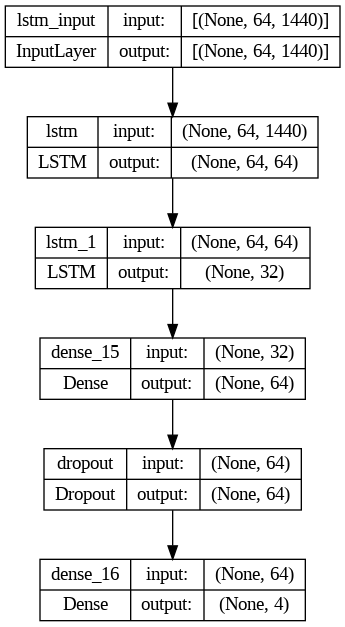

In [137]:
crossval(lstm_model, 100, X_train, y_train, X_test, y_test)

/root/anaconda3/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


--------------------------------------------------
Training for fold 1 ...
Epoch 1/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.2443 - loss: 1.3889
Epoch 2/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.2683 - loss: 1.3860
Epoch 3/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.2581 - loss: 1.3813
Epoch 4/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.2769 - loss: 1.3887
Epoch 5/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.2661 - loss: 1.3858
Epoch 6/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.3093 - loss: 1.3789
Epoch 7/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.2481 - loss: 1.3820
Epoch 8/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.3005 - loss: 1.3729
Epoch 9/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.3003 - loss: 1.3792
Epoch 10/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.2783 - loss: 1.3765
Epoch 11/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy:

In [139]:
def rnn_model():
    """
    The model is described below:

1. SimpleRNN Layers:
    - The first layer is a SimpleRNN (Simple Recurrent Neural Network) layer with 64 units.
    - It takes input sequences of variable length and returns sequences (return_sequences=True).
    - The input shape is determined dynamically based on the shape of input data X.
    - SimpleRNN layers are basic recurrent layers that process input sequences one element at a time, maintaining a hidden state that captures information about previous elements in the sequence.

    - The second layer is another SimpleRNN layer with 32 units.
    - Unlike the first layer, this SimpleRNN layer does not return sequences (return_sequences=False), which means it only outputs the last output in the output sequence.
    - The output of this layer will be a fixed-size vector representing the input sequence.

2. Dense Layers:
    - Following the SimpleRNN layers, there's a Dense (fully connected) layer with 64 units and ReLU activation.
    - Dense layers are added to introduce non-linearity and enable the model to learn complex patterns in the data.

3. Dropout Layer:
    - After the dense layer, a Dropout layer with a dropout rate of 0.2 is added.
    - Dropout is a regularization technique that helps prevent overfitting by randomly dropping a fraction of input units during training.

4. Output Layer:
    - Finally, there's an output layer with 4 units, representing the number of classes or output categories.
    - There is no activation function specified for this layer, which means it will output raw logits.
"""
    model = tf.keras.Sequential([
        tf.keras.layers.SimpleRNN(64, input_shape=X.shape[1:], return_sequences=True),
        tf.keras.layers.SimpleRNN(32),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(4)
    ])
    return model

model = rnn_model()
model.summary()

/root/anaconda3/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_125"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_32 (SimpleRNN)       │ (None, 64, 64)         │        96,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_33 (SimpleRNN)       │ (None, 32)             │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_347 (Dense)               │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_125 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_348 (Dense)               │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 101,796 (397.64 KB)

 Trainable params: 101,796 (397.64 KB)

 Non-trainable params: 0 (0.00 B)

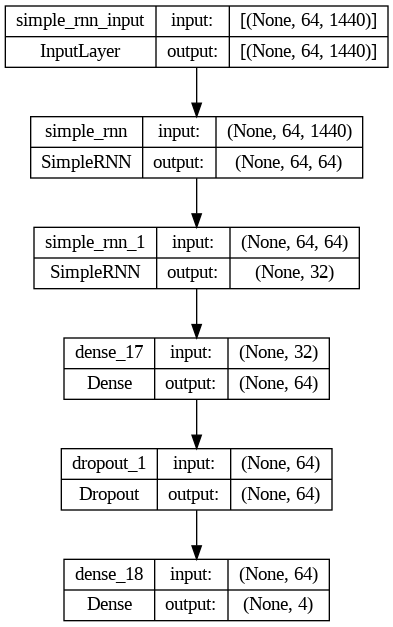

In [140]:
crossval(rnn_model, 40, X_train, y_train, X_test, y_test)

/root/anaconda3/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


--------------------------------------------------
Training for fold 1 ...
Epoch 1/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.2530 - loss: 1.4400
Epoch 2/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.2447 - loss: 1.4075
Epoch 3/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.2288 - loss: 1.4047
Epoch 4/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.2682 - loss: 1.3938
Epoch 5/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.2715 - loss: 1.3908
Epoch 6/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.2843 - loss: 1.3920
Epoch 7/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.2911 - loss: 1.3762
Epoch 8/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.2740 - loss: 1.3675
Epoch 9/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.2907 - loss: 1.3735
Epoch 10/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.3011 - loss: 1.3810
Epoch 11/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.3280 - l

In [142]:
def cnn_lstm_model():
    """
    Model Explanation:
1. Convolutional Layers:
    - The first layer is a 1-dimensional convolutional layer (Conv1D) with 32 filters and a kernel size of 3.
    - It uses the ReLU activation function.
    - The input shape is determined dynamically based on the shape of input data X.

    - Following the first convolutional layer, there's a MaxPooling1D layer with a pool size of 2 and stride of 2.
    - MaxPooling is applied to reduce the spatial dimensions of the feature maps.

    - The second convolutional layer is similar to the first one but with 64 filters.

2. LSTM Layers:
    - After the convolutional layers, there's an LSTM (Long Short-Term Memory) layer with 64 units.
    - It takes input sequences of variable length and returns sequences (return_sequences=True).
    - The output of this layer will be a sequence of vectors.

    - The second LSTM layer is another LSTM with 32 units.
    - Unlike the first layer, this LSTM layer does not return sequences (return_sequences=False), which means it only outputs the last output in the output sequence.

3. Dense Layers:
    - Following the LSTM layers, there's a Dense (fully connected) layer with 64 units and ReLU activation.
    - Dense layers are added to introduce non-linearity and enable the model to learn complex patterns in the data.

4. Dropout Layer:
    - After the dense layer, a Dropout layer with a dropout rate of 0.2 is added.
    - Dropout is a regularization technique that helps prevent overfitting by randomly dropping a fraction of input units during training.

5. Output Layer:
    - Finally, there's an output layer with 4 units, representing the number of classes or output categories.
    - There is no activation function specified for this layer, which means it will output raw logits.
"""
    model = tf.keras.Sequential([
        tf.keras.layers.Conv1D(32, 3, activation='relu', input_shape=X.shape[1:]),
        tf.keras.layers.MaxPooling1D(pool_size=2, strides=2, data_format="channels_last"),
        tf.keras.layers.Conv1D(64, 3, activation='relu'),
        tf.keras.layers.MaxPooling1D(pool_size=2, strides=2, data_format="channels_last"),
        tf.keras.layers.LSTM(64, return_sequences=True),
        tf.keras.layers.LSTM(32),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(4)
    ])
    return model
model = cnn_lstm_model()
model.summary()

/root/anaconda3/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_130"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_114 (Conv1D)             │ (None, 62, 32)         │       138,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_112               │ (None, 31, 32)         │             0 │
│ (MaxPooling1D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_115 (Conv1D)             │ (None, 29, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_113               │ (None, 14, 64)         │             0 │
│ (MaxPooling1D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_108 (LSTM)                 │ (None, 14, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_109 (LSTM)                 │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_357 (Dense)               │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_130 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_358 (Dense)               │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 192,292 (751.14 KB)

 Trainable params: 192,292 (751.14 KB)

 Non-trainable params: 0 (0.00 B)

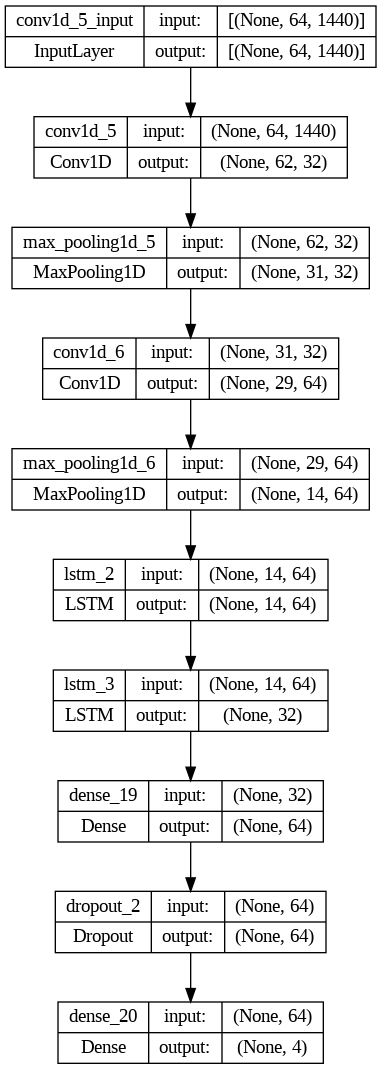

In [143]:
crossval(cnn_lstm_model, 100, X_train, y_train, X_test, y_test)

/root/anaconda3/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


--------------------------------------------------
Training for fold 1 ...
Epoch 1/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.2357 - loss: 1.3983
Epoch 2/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.2447 - loss: 1.3917
Epoch 3/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.2527 - loss: 1.3859
Epoch 4/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.2506 - loss: 1.3865
Epoch 5/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.2469 - loss: 1.3895
Epoch 6/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.2372 - loss: 1.3900
Epoch 7/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.2396 - loss: 1.3883
Epoch 8/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.2884 - loss: 1.3826
Epoch 9/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.2343 - loss: 1.3905
Epoch 10/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.2772 - loss: 1.3874
Epoch 11/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: